In [1]:
!pip uninstall tensorflow-datasets tensorflow-metadata -y
!pip install tensorflow==2.11
!pip install sciann

Found existing installation: tensorflow-datasets 4.9.6
Uninstalling tensorflow-datasets-4.9.6:
  Successfully uninstalled tensorflow-datasets-4.9.6
Found existing installation: tensorflow-metadata 1.15.0
Uninstalling tensorflow-metadata-1.15.0:
  Successfully uninstalled tensorflow-metadata-1.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 57.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-est

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 17.4 MB/s eta 0:00:00


In [2]:
#Paquetes para modelos
import sciann as sn
from sciann.utils import math as scmath
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.11.0 
Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] 



In [ ]:
from google.colab import drive
!{google.colab.executable} -m pip install google.colab
drive.mount('/content/drive')

/bin/bash: line 1: {google.colab.executable}: command not found
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Procesamiento de datos

En este experimento se va a trabajar con:

- Un conjunto de datos reducido (X_train_reduced_u_list, X_test_reduced_u_list) para que los datos respeten dimensiones cuadradas atendiendo.
- Un conjunto de datos ampliado (X_train_reduced_u_list, X_test_reduced_u_list) que respete las dimensiones cuadradas aprovechando todos los datos de entrenamiento proporcionados.

In [ ]:
#Allow loading pickled object arrays stored in npy files.
#Reasons for disallowing pickles include security, as loading pickled data
#can execute arbitrary code. If pickles are disallowed, loading object arrays will fail.
#Estamos trabajando con datos que han sido previamente serializados .
#La serialización es el proceso de convertir un objeto en una secuencia de bytes,
#que luego puede ser almacenada en un archivo.
d_train = np.load('drive/MyDrive/antiderivative_aligned_train.npz', allow_pickle=True)
d_test = np.load('drive/MyDrive/antiderivative_aligned_test.npz', allow_pickle=True)

In [ ]:
#X_train[0] : Matriz nxm que describe las localizaciones u(x1),..., u(xm) en n funciones u distintas.
#X_train[1] : Localizaciones x1,...,xm de los sensores.
#y_train : Matriz nxm que describe la salida esperada G(uj)(xi), para cada j=1,..,n, i=1,...m.
X_train = (d_train["X"][0].astype(np.float32), d_train["X"][1].astype(np.float32))
y_train = d_train["y"].astype(np.float32)


In [ ]:
print("Dimensiones nxm: ",y_train.shape)

Dimensiones nxm:  (150, 100)


In [ ]:
n = y_train.shape[0]
m = y_train.shape[1]

In [ ]:
X_test = (d_test["X"][0].astype(np.float32), d_test["X"][1].astype(np.float32))
y_test = d_test["y"].astype(np.float32)

In [ ]:
X_train_reduc_u_list = [X_train[0][:m,i].flatten()[:None] for i in range(m)]
X_test_reduc_u_list = [X_test[0][:m,i].flatten()[:None] for i in range(m)]

In [ ]:
#Aumento del conjunto de datos
X_train_0_ampliado = np.concatenate([X_train[0][:][:],X_train[0][:,:50]],axis=1)
print(f"Dimensiones de los datos de entrada: {X_train_0_ampliado.shape}")
X_train_1_ampliado = np.concatenate([X_train[1][:],X_train[1][:50]],axis=0)
print(f"Tamaño de la partición: {X_train_1_ampliado.shape}")
y_train_ampliado = np.concatenate([y_train[:][:],y_train[:,:50]],axis=1)
print(f"Dimensiones de la salida: {y_train_ampliado.shape}")

Dimensiones de los datos de entrada: (150, 150)
Tamaño de la partición: (150, 1)
Dimensiones de la salida: (150, 150)


In [ ]:
X_test_0_ampliado = np.concatenate([X_test[0][:][:],X_test[0][:,:50]],axis=1)
print(f"Dimensiones de los datos de entrada: {X_test_0_ampliado.shape}")
X_test_1_ampliado = np.concatenate([X_test[1][:],X_test[1][:50]],axis=0)
print(f"Tamaño de la partición: {X_test_1_ampliado.shape}")
y_test_ampliado = np.concatenate([y_test[:][:],y_test[:,:50]],axis=1)
print(f"Dimensiones de la salida: {y_train_ampliado.shape}")

Dimensiones de los datos de entrada: (1000, 150)
Tamaño de la partición: (150, 1)
Dimensiones de la salida: (150, 150)


In [ ]:
n = y_train_ampliado.shape[0]
m = y_train_ampliado.shape[1]

In [ ]:
X_train_ampl_u_list = [X_train_0_ampliado[:m,i].flatten()[:None] for i in range(m)]
X_test_ampl_u_list = [X_test_0_ampliado[:m,i].flatten()[:None] for i in range(m)]
#Comprobamos que hemos realizado la repartición correcta de los datos
# print(X_train_u_list[0],X_train_[:,0])
# print(X_train_u_list[0],X_train_u_list[100])

#Definición del modelo.

In [ ]:
def modelo_operador(N,m):
    #Definición de las entradas
    x = sn.Variable("x")
    ux = [sn.Variable(f'ux{i}') for i in range(m)]


    #Definición de subredes

    subnet_branches = [sn.Functional(f'branch_out_{i}', ux, [1], activation='sigmoid') for i in range(N)]
    subnet_trunk = sn.Functional("trunk_out",x ,[N], 'sigmoid')

    #Construcción manual del producto cartesiano de las subredes
    productos = []

    for i in range(N):
      productos.append(sn.utils.mul(subnet_branches[i],subnet_trunk))

    s = sn.utils.add(productos[0],productos[1])

    for i in range(2,N):
      s = sn.utils.add(s,productos[i])

    #Restricciones del modelo
    d1 = sn.Data(s)

    # Definimos el modelo
    return sn.SciModel(inputs = ux+[x], targets=[d1], loss_func='MSE',optimizer="adam",plot_to_file=f"operador_{m}_{N}.png")


In [ ]:
#Número de neuronas consideradas en el ejemplo de DeepONet
N=40

#Definición de las entradas
x = sn.Variable("x")
ux = [sn.Variable(f'ux{i}') for i in range(m)]


#Definición de subredes

subnet_branches = [sn.Functional(f'branch_out_{i}', ux, [1], activation='tanh') for i in range(N)]
subnet_trunk = sn.Functional("trunk_out",x ,[N], 'sigmoid')

#Construcción manual del producto cartesiano de las subredes
productos = []

for i in range(N):
  productos.append(sn.utils.mul(subnet_branches[i],subnet_trunk))

s = sn.utils.add(productos[0],productos[1])

for i in range(2,N):
  s = sn.utils.add(s,productos[i])

#Restricciones del modelo
d1 = sn.Data(s)

# Definimos el modelo
modelo_operador= sn.SciModel(inputs = ux+[x], targets=[d1], loss_func='MSE',optimizer="adam",plot_to_file="operador_b.png")

# Resumen del modelo
modelo_operador.summary()

In [ ]:
modelo_N_40_m_100 = modelo_operador(N=40,m=m)

#Entrenamiento del modelo.

In [ ]:
n_neuronas = [40,80]

modelos_m_100 = []
entrenamientos_m_100 = []
duracion_entrenamientos_m_100 = []

for n in n_neuronas:
  print(f"--- {n} neuronas ---")
  modelo = modelo_operador(N=n,m=100)
  modelos_m_100.append(modelo)
  start_time = time.time()
  entrenamientos_m_100.append(modelo.train(
                           X_train_reduced_u_list+[X_train[1]],y_train,
                           batch_size=100,
                           epochs=5000,
                           learning_rate={"scheduler": "ExponentialDecay",
                                          "initial_learning_rate": 1e-2,
                                          "final_learning_rate": 1e-4,
                                          "decay_epochs": 10,
                                          "verify": False},
                            callbacks=[kerabs.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=10,verbose=1)],
                            validation_data=(X_test_reduced_u_list + [X_test[1]], y_test)))

  duracion_entrenamientos_m_100.append(time.time()-start_time)

--- 40 neuronas ---

Total samples: 100 
Batch size: 100 
Total batches: 1 

Epoch 1/5000
1/1 [==============================] - ETA: 0s - batch: 0.0000e+00 - size: 100.0000 - loss: 2.8838

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1/1 [==============================] - 6s 6s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 2.8838 - val_loss: 1.1942 - lr: 0.0100 - time: 6.2037
Epoch 2/5000
1/1 [==============================] - 5s 5s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.9995 - val_loss: 0.3696 - lr: 0.0063 - time: 4.8822
Epoch 3/5000
1/1 [==============================] - 5s 5s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.4205 - val_loss: 0.2087 - lr: 0.0040 - time: 4.5987
Epoch 4/5000
1/1 [==============================] - 4s 4s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.3250 - val_loss: 0.2170 - lr: 0.0025 - time: 4.3717
Epoch 5/5000
1/1 [==============================] - 7s 7s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.3356 - val_loss: 0.2485 - lr: 0.0016 - time: 6.8558
Epoch 6/5000
1/1 [==============================] - 5s 5s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.3526 - val_loss: 0.2711 - lr: 0.0010 - time: 5.2928
Epoch 7/5000
1/1 [=======================

In [ ]:
start_time = time.time()
training_history = modelo_operador.train(X_train_reduced_u_list+[X_train[1]],y_train,batch_size=100,epochs=5000,learning_rate = 0.01,callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=20,verbose=1)])
print(f"Duración del entrenamiento: {time.time()-start_time}s. ")



Total samples: 100 
Batch size: 100 
Total batches: 1 

Epoch 1/5000
1/1 [==============================] - 10s 10s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 1.2698 - lr: 0.0100 - time: 10.0549
Epoch 2/5000
1/1 [==============================] - 0s 71ms/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.4288 - lr: 0.0100 - time: 0.0747
Epoch 3/5000
1/1 [==============================] - 0s 62ms/step - batch: 0.0000e+00 - size: 100.0000 - loss: 8.3147 - lr: 0.0100 - time: 0.0641
Epoch 4/5000
1/1 [==============================] - 0s 104ms/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.8292 - lr: 0.0100 - time: 0.1058
Epoch 5/5000
1/1 [==============================] - 0s 97ms/step - batch: 0.0000e+00 - size: 100.0000 - loss: 1.3681 - lr: 0.0100 - time: 0.0984
Epoch 6/5000
1/1 [==============================] - 0s 100ms/step - batch: 0.0000e+00 - size: 100.0000 - loss: 2.9375 - lr: 0.0100 - time: 0.1022
Epoch 7/5000
1/1 [==============================] - 0s 86ms/step - bat

In [ ]:
s_pred =  s.eval(modelo_operador,X_test_reduced_u_list+[X_test[1]])

#MAE = np.mean(np.abs(u_pred_Simb-u_pred_sciann))*20
MSE = np.mean((y_test[:m]-s_pred)**2)
MSE

0.3101259

In [ ]:
#print(s_pred.shape)

Repetimos el experimento con el conjunto de entrenamiento aumentado:

#Procesamiento de datos.
Adaptamos las entradas al formato que requiere SciANN y aumentamos el conjunto de datos.

In [ ]:
#Aumento del conjunto de datos
X_train_0_ampliado = np.concatenate([X_train[0][:][:],X_train[0][:,:50]],axis=1)
print(f"Dimensiones de los datos de entrada: {X_train_0_ampliado.shape}")
X_train_1_ampliado = np.concatenate([X_train[1][:],X_train[1][:50]],axis=0)
print(f"Tamaño de la partición: {X_train_1_ampliado.shape}")
y_train_ampliado = np.concatenate([y_train[:][:],y_train[:,:50]],axis=1)
print(f"Dimensiones de la salida: {y_train_ampliado.shape}")

Dimensiones de los datos de entrada: (150, 150)
Tamaño de la partición: (150, 1)
Dimensiones de la salida: (150, 150)


In [ ]:
X_test_0_ampliado = np.concatenate([X_test[0][:][:],X_test[0][:,:50]],axis=1)
print(f"Dimensiones de los datos de entrada: {X_test_0_ampliado.shape}")
X_test_1_ampliado = np.concatenate([X_test[1][:],X_test[1][:50]],axis=0)
print(f"Tamaño de la partición: {X_test_1_ampliado.shape}")
y_test_ampliado = np.concatenate([y_test[:][:],y_test[:,:50]],axis=1)
print(f"Dimensiones de la salida: {y_train_ampliado.shape}")

Dimensiones de los datos de entrada: (1000, 150)
Tamaño de la partición: (150, 1)
Dimensiones de la salida: (150, 150)


In [ ]:
n = y_train_ampliado.shape[0]
m = y_train_ampliado.shape[1]

In [ ]:
X_train_u_list = [X_train_0_ampliado[:m,i].flatten()[:None] for i in range(m)]
X_test_u_list = [X_test_0_ampliado[:m,i].flatten()[:None] for i in range(m)]
#Comprobamos que hemos realizado la repartición correcta de los datos
# print(X_train_u_list[0],X_train_[:,0])
# print(X_train_u_list[0],X_train_u_list[100])

In [ ]:
len(X_test_u_list[0])

150

In [ ]:
#Número de neuronas consideradas en el ejemplo de DeepONet
N=40

#Definición de las entradas
x = sn.Variable("x")
ux = [sn.Variable(f'ux{i}') for i in range(m)]


#Definición de subredes

subnet_branches = [sn.Functional(f'branch_out_{i}', ux, [1], activation='tanh') for i in range(N)]
subnet_trunk = sn.Functional("trunk_out",x ,[N], 'sigmoid')

#Construcción manual del producto cartesiano de las subredes
productos = []

for i in range(N):
  productos.append(sn.utils.mul(subnet_branches[i],subnet_trunk))

s = sn.utils.add(productos[0],productos[1])

for i in range(2,N):
  s = sn.utils.add(s,productos[i])

#Restricciones del modelo
d1 = sn.Data(s)

# Definimos el modelo
modelo_operador= sn.SciModel(inputs = ux+[x], targets=[d1], loss_func='MSE',optimizer="adam",plot_to_file="operador_b.png")

# Resumen del modelo
modelo_operador.summary()

Se han truncado las últimas 5000 líneas del flujo de salida.
                                                                  'ux117[0][0]',                  
                                                                  'ux118[0][0]',                  
                                                                  'ux119[0][0]',                  
                                                                  'ux120[0][0]',                  
                                                                  'ux121[0][0]',                  
                                                                  'ux122[0][0]',                  
                                                                  'ux123[0][0]',                  
                                                                  'ux124[0][0]',                  
                                                                  'ux125[0][0]',                  
                                                

In [ ]:
X_train[1].shape

(100, 1)

In [ ]:
start_time = time.time()
training_history_aumentado = modelo_operador.train(X_train_u_list+[X_train_1_ampliado],y_train_ampliado,batch_size=100,epochs=5000,learning_rate = 0.01,callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=20,verbose=1)])
print(f"Duración del entrenamiento: {time.time()-start_time}s. ")


Total samples: 150 
Batch size: 100 
Total batches: 2 

Epoch 1/5000
2/2 [==============================] - 12s 356ms/step - batch: 0.5000 - size: 75.0000 - loss: 5.3173 - lr: 0.0100 - time: 12.4460
Epoch 2/5000
2/2 [==============================] - 0s 60ms/step - batch: 0.5000 - size: 75.0000 - loss: 2.1463 - lr: 0.0100 - time: 0.1201
Epoch 3/5000
2/2 [==============================] - 0s 62ms/step - batch: 0.5000 - size: 75.0000 - loss: 2.0937 - lr: 0.0100 - time: 0.1164
Epoch 4/5000
2/2 [==============================] - 0s 78ms/step - batch: 0.5000 - size: 75.0000 - loss: 0.2795 - lr: 0.0100 - time: 0.1451
Epoch 5/5000
2/2 [==============================] - 0s 66ms/step - batch: 0.5000 - size: 75.0000 - loss: 0.3066 - lr: 0.0100 - time: 0.1367
Epoch 6/5000
2/2 [==============================] - 0s 77ms/step - batch: 0.5000 - size: 75.0000 - loss: 0.2819 - lr: 0.0100 - time: 0.1269
Epoch 7/5000
2/2 [==============================] - 0s 88ms/step - batch: 0.5000 - size: 75.0000 - l

In [ ]:
s_pred_aumentado =  s.eval(modelo_operador,X_test_u_list+[X_test_1_ampliado])

#MAE = np.mean(np.abs(u_pred_Simb-u_pred_sciann))*20
MSE = np.mean((y_test_ampliado[:m]-s_pred_aumentado)**2)
MSE

0.4277983

In [ ]:
plt.legend()
plt.xlabel('Época')
plt.ylabel('Pérdida')

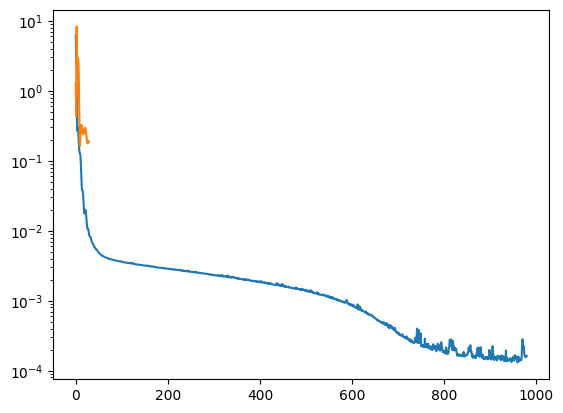

In [ ]:
plt.semilogy(training_history_aumentado.history['loss'])
plt.semilogy(training_history.history['loss'])